<a href="https://colab.research.google.com/github/ShivamSinghal1/FacialEmotionRecognition/blob/master/CK%2B.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential , load_model
from keras.layers import Convolution2D, Activation, BatchNormalization, MaxPooling2D, Dropout, Dense, Flatten, AveragePooling2D
from keras.initializers import  RandomNormal
from keras.layers import Conv2D,MaxPooling2D
from keras.optimizers import RMSprop,SGD,Adam
from keras.callbacks import ModelCheckpoint, TensorBoard ,EarlyStopping, ReduceLROnPlateau

import numpy as np
import pandas as pd

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = "/content/drive/My Drive/Dataset/CK+48"
datagen = ImageDataGenerator(rescale=1. / 255,
                             shear_range=0.3,
                             zoom_range=0.2,
                             validation_split = 0.2,
                             horizontal_flip=True)
train_generator = datagen.flow_from_directory(data_dir,
                                              target_size=(48,48),
                                              batch_size=4,
                                              color_mode="grayscale",
                                              subset="training",
                                              class_mode='categorical')
validation_generator = datagen.flow_from_directory(data_dir,
                                              target_size=(48,48),
                                              batch_size=4,
                                              color_mode="grayscale",
                                              subset="validation",
                                              class_mode='categorical')

Found 788 images belonging to 7 classes.
Found 193 images belonging to 7 classes.


In [ ]:
def get_cnn_model():
    model = Sequential()

    model.add(Convolution2D(64, (3, 1), padding='same', input_shape=(48,48,1)))
    model.add(Convolution2D(64, (1, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(128, (3, 1), padding='same'))
    model.add(Convolution2D(128, (1, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(256, (3, 1), padding='same'))
    model.add(Convolution2D(256, (1, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Convolution2D(512, (3, 1), padding='same'))
    model.add(Convolution2D(512, (1, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2), strides=None, padding='same'))
    model.add(Dropout(0.25))

    model.add(Flatten())

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(7))
    model.add(Activation('softmax'))
    return model

In [ ]:
model = get_cnn_model()

In [ ]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 48, 48, 64)        256       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 48, 48, 64)        12352     
_________________________________________________________________
batch_normalization (BatchNo (None, 48, 48, 64)        256       
_________________________________________________________________
activation (Activation)      (None, 48, 48, 64)        0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 24, 24, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 24, 24, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 24, 24, 128)       2

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer = Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-7),
              metrics=['accuracy'])


# Saving model each time it achieves lower loss on the validation set
filepath='/content/drive/My Drive/Dataset/ck_vgg16_v2.hdf5'
checkpointer = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='auto')

earlystop = EarlyStopping(monitor='val_loss',
                          min_delta=0,
                          patience=8,
                          verbose=1,
                          restore_best_weights=True, mode = 'auto'
                          )

reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                              factor=0.9,
                              patience=3,
                              verbose=1,
                              min_delta=0.0001)


history = model.fit(train_generator,
                    epochs=300,
                    validation_data=validation_generator,
                    callbacks=[checkpointer,earlystop,reduce_lr]
                             )

pd.DataFrame(history.history).to_csv("/content/drive/My Drive/Dataset/ck_history.csv")

In [ ]:
import matplotlib.pyplot as plt

fig = plt.figure()
plt.subplot(2,1,1)
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='lower right')

plt.subplot(2,1,2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper right')

plt.tight_layout()

In [ ]:
def eval_model(history, model):
    batch_size = 32
    score = model.evaluate(X_test, Y_test, steps=(int)(len(X_test) / batch_size))
    print('Evaluation loss: ', score[0])
    print('Evaluation accuracy: ', score[1])
    # summarize history for accuracy
    plt.plot(history.history['acc'], color='b', label='Training')
    plt.plot(history.history['val_acc'], color='g', label='Validation')
    plt.title('Accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(loc='upper left')
    plt.show()

    # summarize history for loss
    plt.plot(history.history['loss'], color='b', label='Training')
    plt.plot(history.history['val_loss'], color='g', label='Validation')
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(loc='lower left')
    plt.show()
    y_pred = model.predict_classes(X_test)
    y_true = np.asarray([np.argmax(i) for i in Y_test])

    from sklearn.metrics import confusion_matrix
    import seaborn as sns

    cm = confusion_matrix(y_true, y_pred)
    cm_normalised = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    sns.set(font_scale=1.5) 
    fig, ax = plt.subplots(figsize=(10,10))
    ax = sns.heatmap(cm_normalised, annot=True, linewidths=0, square=False, 
                        cmap="Greens", yticklabels=labels, xticklabels=labels, vmin=0, vmax=np.max(cm_normalised), 
                        fmt=".2f", annot_kws={"size": 20})
    ax.set(xlabel='Predicted label', ylabel='True label')

In [ ]:
model.evaluate(validation_generator)
model.save('/content/drive/My Drive/Dataset/final_ck_vgg16_v2.hdf5')

In [ ]:
model = load_model('/content/drive/My Drive/Dataset/ck_vgg16_v2.hdf5')

In [ ]:
model.evaluate(validation_generator)

In [ ]:
y_test = []
X_test = []
for i in range(0,49):
    X = validation_generator.__getitem__(i)[0]
    Y = validation_generator.__getitem__(i)[1]
    for y in Y:
      y_test.append(np.argmax(y))
    for x in X:
      X_test.append(x)
X_test = np.array(X_test)
y_test = np.array(y_test)

In [ ]:
y_predict = model.predict_classes(X_test)

Instructions for updating:
Please use instead:* `np.argmax(model.predict(x), axis=-1)`,   if your model does multi-class classification   (e.g. if it uses a `softmax` last-layer activation).* `(model.predict(x) > 0.5).astype("int32")`,   if your model does binary classification   (e.g. if it uses a `sigmoid` last-layer activation).


In [ ]:
# Plot confusion matrix 
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

def create_confmat(true_labels, predicted_labels, columns, colour = 'Greens', size = (20,14)):
    
    cm = confusion_matrix(true_labels, predicted_labels) 
    cm_df = pd.DataFrame(cm,
    index = [col for col in columns], 
    columns = [col for col in columns])
    plt.figure(figsize=(18,16))
    sns.heatmap(cm_df, annot = True, cmap = colour, fmt='g', linewidths=.2)
    plt.title('Confusion Matrix', fontsize = 20)
    plt.ylabel('True label', fontsize = 18)
    plt.xlabel('Predicted label', fontsize = 18)
    plt.tick_params(axis='both', labelsize=14)
    plt.show()

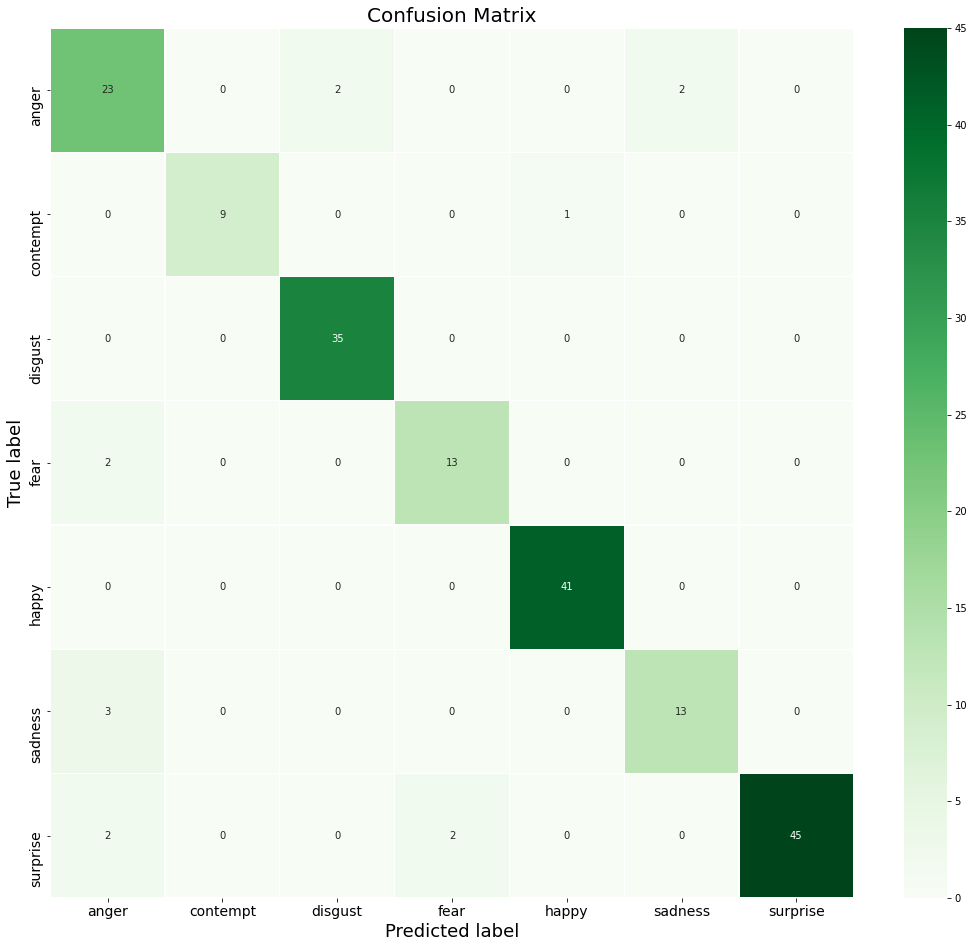

In [ ]:
create_confmat(y_test , y_predict , ['anger' , 'contempt' , 'disgust' , 'fear' , 'happy' , 'sadness' , 'surprise'])

In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test , y_predict))

              precision    recall  f1-score   support

           0       0.77      0.85      0.81        27
           1       1.00      0.90      0.95        10
           2       0.95      1.00      0.97        35
           3       0.87      0.87      0.87        15
           4       0.98      1.00      0.99        41
           5       0.87      0.81      0.84        16
           6       1.00      0.92      0.96        49

    accuracy                           0.93       193
   macro avg       0.92      0.91      0.91       193
weighted avg       0.93      0.93      0.93       193



# SVM Trial Version 

In [ ]:
y_test = []
X_test = []
for i in range(0,49):
    X = validation_generator.__getitem__(i)[0]
    Y = validation_generator.__getitem__(i)[1]
    for y in Y:
      y_test.append(np.argmax(y))
    for x in X:
      X_test.append(x)

In [ ]:
X_test = np.array(X_test)
X_test = X_test.reshape(X_test.shape[0],224*224*3)
y_test = np.array(y_test)
X_test.shape , y_test.shape

((193, 150528), (193,))

In [ ]:
y_train = []
X_train = []
for i in range(0,197):
    X = train_generator.__getitem__(i)[0]
    Y = train_generator.__getitem__(i)[1]
    for y in Y:
      y_train.append(np.argmax(y))
    for x in X:
      X_train.append(x)

In [ ]:
X_train = np.array(X_train)
X_train = X_train.reshape(X_train.shape[0],224*224*3)
y_train = np.array(y_train)
X_train.shape , y_train.shape

((788, 150528), (788,))

In [ ]:
from sklearn.svm import SVC
model = SVC()
model.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

In [ ]:
model.score(X_test , y_test)

0.6269430051813472

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='linear', probability=True)
model.fit(X_train,y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=True, random_state=None, shrinking=True, tol=0.001,
    verbose=False)

In [ ]:
model.score(X_test , y_test)

0.694300518134715

In [ ]:
from sklearn.svm import SVC
model = SVC(kernel='rbf', probability=True)
model.fit(X_train,y_train)
model.score(X_test , y_test)

0.6373056994818653

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
param_grid = {'C': [0.1, 1, 10, 100, 1000],  
              'gamma': [1, 0.1, 0.01, 0.001, 0.0001], 
              'kernel': ['rbf']} 

          # , 0.001, 0.005, 0.01, 0.1
# for sklearn version 0.16 or prior, the class_weight parameter value is 'auto'
clf = GridSearchCV(SVC(kernel='linear', class_weight='balanced'), param_grid,refit = True, verbose = 3)
clf = clf.fit(X_train, y_train)

Fitting 5 folds for each of 25 candidates, totalling 125 fits
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.139, total= 3.6min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  3.6min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.139, total= 3.6min
[CV] C=0.1, gamma=1, kernel=rbf ......................................


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:  7.2min remaining:    0.0s


[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.139, total= 3.6min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.185, total= 3.6min
[CV] C=0.1, gamma=1, kernel=rbf ......................................
[CV] .......... C=0.1, gamma=1, kernel=rbf, score=0.210, total= 3.6min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.139, total= 3.7min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.139, total= 3.6min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.139, total= 3.7min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] ........ C=0.1, gamma=0.1, kernel=rbf, score=0.185, total= 3.6min
[CV] C=0.1, gamma=0.1, kernel=rbf ....................................
[CV] .

[Parallel(n_jobs=1)]: Done 125 out of 125 | elapsed: 436.1min finished


In [ ]:
print(clf.best_estimator_)

SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)


In [ ]:
#SVC(C=10, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
 #   decision_function_shape='ovr', degree=3, gamma=0.0001, kernel='rbf',
  #  max_iter=-1, probability=False, random_state=None, shrinking=True,
   # tol=0.001, verbose=False)
from sklearn.metrics import classification_report

y_pred = clf.predict(X_test)
print(classification_report(y_test, y_pred))


              precision    recall  f1-score   support

           0       0.38      0.70      0.49        27
           1       0.40      0.40      0.40        10
           2       0.54      0.63      0.58        35
           3       0.50      0.27      0.35        15
           4       0.97      0.90      0.94        41
           5       0.50      0.06      0.11        16
           6       0.86      0.78      0.82        49

    accuracy                           0.65       193
   macro avg       0.59      0.53      0.53       193
weighted avg       0.68      0.65      0.64       193



In [ ]:
create_confmat(y_test , y_pred , ['anger' , 'contempt' , 'disgust' , 'fear' , 'happy' , 'sadness' , 'surprise'])